In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

### Загрузка данных

**Описание датасета**

Суть проекта — оптимизировать полеты зимнего периода.

* **flight_id** — уникальный номер рейса
* **departure_airport** — аэропорт отправления
* **city** — город отправления
* **arrival_airport** — аэропорт прибытия
* **city_arrival** — город прибытия
* **model** — модель самолета
* **ticket_economy** — класс обслуживания "эконом"
* **ticket_comfort** — класс обслуживания "комфорт"
* **ticket_business** — класс обслуживания "бизнес"
* **seat** — общее количество посадочных мест в самолете
* **amount** — общая стоимость проданных билетов на рейс
* **time_actual** — реальное время полета 
* **time_scheduled** — запланированное время полета

In [2]:
import warnings
from pylab import rcParams
%config InlineBackend.figure_format = 'svg'
rcParams['figure.figsize'] = 12, 6

warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

df = pd.read_csv('project_4_1.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 13 columns):
flight_id            127 non-null int64
departure_airport    127 non-null object
city                 127 non-null object
arrival_airport      127 non-null object
city_arrival         127 non-null object
model                127 non-null object
ticket_economy       118 non-null float64
ticket_comfort       118 non-null float64
ticket_business      118 non-null float64
seat                 127 non-null int64
amount               118 non-null float64
time_actual          127 non-null float64
time_scheduled       127 non-null float64
dtypes: float64(6), int64(2), object(5)
memory usage: 13.0+ KB


In [5]:
df

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_comfort,ticket_business,seat,amount,time_actual,time_scheduled
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102.0,0.0,11.0,130,1653000.0,101.0,100.0
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87.0,0.0,10.0,130,1431000.0,100.0,100.0
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97.0,0.0,10.0,130,1556600.0,99.0,100.0
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103.0,0.0,12.0,130,1700600.0,98.0,100.0
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99.0,0.0,11.0,130,1617600.0,99.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,0.0,12.0,97,765300.0,51.0,50.0
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,0.0,12.0,97,765300.0,51.0,50.0
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75.0,0.0,12.0,97,702300.0,50.0,50.0
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,0.0,12.0,97,765300.0,50.0,50.0


Проанализируем полученный датасет, для оценки прибыльности выберем самую простую модель: стоимость билетов - стоимость топлива на рейс.

### Обработка пропусков

Проанализируем колонки с пропусками:
    ticket_economy,
    ticket_comfort,
    ticket_business,
    amount

Заполним пустые ячейки None

In [6]:
df.amount.replace('', np.nan, inplace = True)

In [7]:
df.amount = df.amount.astype(str).apply(lambda x: 0 if x.strip() == '' else x)

In [8]:
df.loc[df.amount == 'nan']

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_comfort,ticket_business,seat,amount,time_actual,time_scheduled
18,136511,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,310.0,305.0
19,136523,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,312.0,305.0
20,136540,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,307.0,305.0
21,136546,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,302.0,305.0
44,136513,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,310.0,305.0
45,136514,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,299.0,305.0
46,136567,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,311.0,305.0
81,136560,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,305.0,305.0
114,136544,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,NaN,NaN,NaN,130,nan,304.0,305.0


Все 9 пустых ячеек в интересующих нас колонках относятся к рейсам из Анапы в Новокузнецк. 
Проведя анализ базы данных было выясняно, что информация по рейсам из Анапы в Новокузнецк отсутствует в любое время года.
В базе данных есть информация по рейсам Краснодар-Новокузнецк. Запланированное время полета отличается на 10 мин.
Проанализируем эти рейсы в зимний период (запрос представлен в блокноте).

In [9]:
df_1 = pd.read_csv('project_krr.csv')

In [10]:
df_1

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_comfort,ticket_business,seat,amount,actual_arrival,time_actual,time_scheduled
0,157563,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,11,0,0,130,386100.0,2017-01-07T13:49:00Z,296.0,295.0
1,157570,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,9,0,3,130,639100.0,2016-12-17T13:51:00Z,299.0,295.0
2,157586,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,12,0,0,130,421200.0,2017-02-11T16:22:00Z,294.0,295.0
3,157597,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,10,0,1,130,456400.0,2016-12-24T13:51:00Z,295.0,295.0
4,157600,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,10,0,2,130,561800.0,2016-12-03T13:46:00Z,294.0,295.0
5,157610,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,9,0,3,130,642600.0,2017-02-18T13:41:00Z,289.0,295.0
6,157612,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,11,0,1,130,491500.0,2016-12-31T13:55:00Z,298.0,295.0
7,157587,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,9,0,2,130,530200.0,2017-01-28T13:51:00Z,293.0,295.0
8,157598,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,11,0,1,130,491500.0,2017-02-04T13:52:00Z,299.0,295.0
9,157567,KRR,Krasnodar,NOZ,Novokuznetsk,Boeing 737-300,10,0,2,130,568800.0,2017-02-25T13:49:00Z,296.0,295.0


In [11]:
df_1.ticket_economy.median()

10.0

In [12]:
df_1.ticket_business.median()

1.0

In [13]:
df_1.amount.median()

491500.0

Стоимость билетов для 10 мест эконом класса и одного места бизнес класса составляет 456400. Возьмем эту стоимость вместо медианы. Заполним пустые ячейки полученными значениями.

In [14]:
df['ticket_economy'].replace('', np.nan, inplace = True)

In [15]:
df.ticket_economy = df.ticket_economy.astype(str).apply(lambda x: None if x.strip() == '' else x)

In [16]:
df.loc[df['ticket_economy'] == 'nan', 'ticket_economy'] = 10

In [17]:
df.ticket_business.replace('', np.nan, inplace = True)

In [18]:
df.ticket_business = df.ticket_business.astype(str).apply(lambda x: None if x.strip() == '' else x)

In [19]:
df.loc[df['ticket_business'] == 'nan', 'ticket_business'] = 1

In [20]:
df['amount'].replace('', np.nan, inplace = True)

In [21]:
df.amount = df.amount.astype(str).apply(lambda x: None if x.strip() == '' else x)

In [22]:
df.loc[df['amount'] == 'nan', 'amount'] = 456400

In [23]:
df.loc[df.city_arrival == 'Novokuznetsk']

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_comfort,ticket_business,seat,amount,time_actual,time_scheduled
18,136511,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,310.0,305.0
19,136523,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,312.0,305.0
20,136540,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,307.0,305.0
21,136546,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,302.0,305.0
44,136513,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,310.0,305.0
45,136514,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,299.0,305.0
46,136567,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,311.0,305.0
81,136560,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,305.0,305.0
114,136544,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,NaN,1,130,456400,304.0,305.0


Рассмотрим колонку ticket_comfort, кроме пустых ячек, остальные ячейки равны 0, то есть на этих рейсах не предусмотрен такой класс обслуживания. То есть колонку можно удалить.

In [24]:
df.ticket_comfort.value_counts()

0.0    118
Name: ticket_comfort, dtype: int64

In [25]:
df.drop(columns = 'ticket_comfort', inplace = True)

Колонок с пустыми ячейками не осталось.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 12 columns):
flight_id            127 non-null int64
departure_airport    127 non-null object
city                 127 non-null object
arrival_airport      127 non-null object
city_arrival         127 non-null object
model                127 non-null object
ticket_economy       127 non-null object
ticket_business      127 non-null object
seat                 127 non-null int64
amount               127 non-null object
time_actual          127 non-null float64
time_scheduled       127 non-null float64
dtypes: float64(2), int64(2), object(8)
memory usage: 12.0+ KB


In [27]:
df.model.unique()

array(['Boeing 737-300', 'Sukhoi Superjet-100'], dtype=object)

Для расчета стоимости затраченного топлива необходимо знать расход топлива и его стоимость.
Расход топлива для Boeing 737-300 - 2600 кг/ч, для Sukhoi Superjet-100 - 1700 кг/ч. Так как фактическое время полета в нашем датасете представлено в минутах переведем расход кг/мин и получим:
Boeing 737-300 - 43,3 кг/мин, Sukhoi Superjet-100 - 28,3 кг/мин. Создадим колонку с расходом топлива.

In [28]:
def fuel_consum(x):
    if x == 'Boeing 737-300':
        return 43.3
    elif x == 'Sukhoi Superjet-100':
        return 28.3

In [29]:
df['fuel_consum'] = df.model.apply(fuel_consum) #расход топлива кг/мин

In [30]:
df

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102.0,11.0,130,1653000.0,101.0,100.0,43.3
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87.0,10.0,130,1431000.0,100.0,100.0,43.3
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97.0,10.0,130,1556600.0,99.0,100.0,43.3
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103.0,12.0,130,1700600.0,98.0,100.0,43.3
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99.0,11.0,130,1617600.0,99.0,100.0,43.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75.0,12.0,97,702300.0,50.0,50.0,28.3
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,50.0,50.0,28.3


Из открытых источников узнаем стоимость тонны топлива за январь и февраль 2017 года (рейсы за декабрь 2017 года в полученном датасете отсутствуют).
Средняя стоимость топлива за зимние месяцы 2017 года была 40494 руб за тонну. Создадим колонку с этим значением.

In [31]:
df['fuel cost'] = 40494 #средняя стоимость тонны топлива за январь-февраль

In [32]:
df

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102.0,11.0,130,1653000.0,101.0,100.0,43.3,40494
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87.0,10.0,130,1431000.0,100.0,100.0,43.3,40494
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97.0,10.0,130,1556600.0,99.0,100.0,43.3,40494
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103.0,12.0,130,1700600.0,98.0,100.0,43.3,40494
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99.0,11.0,130,1617600.0,99.0,100.0,43.3,40494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3,40494
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3,40494
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75.0,12.0,97,702300.0,50.0,50.0,28.3,40494
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,50.0,50.0,28.3,40494


Посчитаем стоимость израсходованного топлива.

In [33]:
df['total expense'] = round(((df.time_actual * df.fuel_consum)/1000)*df['fuel cost'],2)

In [34]:
df

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102.0,11.0,130,1653000.0,101.0,100.0,43.3,40494,177092.41
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87.0,10.0,130,1431000.0,100.0,100.0,43.3,40494,175339.02
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97.0,10.0,130,1556600.0,99.0,100.0,43.3,40494,173585.63
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103.0,12.0,130,1700600.0,98.0,100.0,43.3,40494,171832.24
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99.0,11.0,130,1617600.0,99.0,100.0,43.3,40494,173585.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3,40494,58444.99
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3,40494,58444.99
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75.0,12.0,97,702300.0,50.0,50.0,28.3,40494,57299.01
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,50.0,50.0,28.3,40494,57299.01


Вычислим прибыльность рейса.

In [35]:
df.amount = df.amount.astype(float)

In [36]:
df['benefit'] = round(df.amount - df['total expense'],2)

In [37]:
df

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense,benefit
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102.0,11.0,130,1653000.0,101.0,100.0,43.3,40494,177092.41,1475907.59
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87.0,10.0,130,1431000.0,100.0,100.0,43.3,40494,175339.02,1255660.98
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97.0,10.0,130,1556600.0,99.0,100.0,43.3,40494,173585.63,1383014.37
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103.0,12.0,130,1700600.0,98.0,100.0,43.3,40494,171832.24,1528767.76
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99.0,11.0,130,1617600.0,99.0,100.0,43.3,40494,173585.63,1444014.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75.0,12.0,97,702300.0,50.0,50.0,28.3,40494,57299.01,645000.99
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,50.0,50.0,28.3,40494,57299.01,708000.99


In [38]:
df.benefit.min()

-90657.74

In [39]:
df.loc[df.benefit <0]

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense,benefit
18,136511,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,310.0,305.0,43.3,40494,543550.96,-87150.96
19,136523,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,312.0,305.0,43.3,40494,547057.74,-90657.74
20,136540,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,307.0,305.0,43.3,40494,538290.79,-81890.79
21,136546,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,302.0,305.0,43.3,40494,529523.84,-73123.84
44,136513,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,310.0,305.0,43.3,40494,543550.96,-87150.96
45,136514,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,299.0,305.0,43.3,40494,524263.67,-67863.67
46,136567,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,311.0,305.0,43.3,40494,545304.35,-88904.35
81,136560,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,305.0,305.0,43.3,40494,534784.01,-78384.01
114,136544,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,304.0,305.0,43.3,40494,533030.62,-76630.62


Посчитаем процент проданных мест на рейс.

In [44]:
df_3 = df.copy()

In [45]:
df_3

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense,benefit
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102.0,11.0,130,1653000.0,101.0,100.0,43.3,40494,177092.41,1475907.59
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87.0,10.0,130,1431000.0,100.0,100.0,43.3,40494,175339.02,1255660.98
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97.0,10.0,130,1556600.0,99.0,100.0,43.3,40494,173585.63,1383014.37
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103.0,12.0,130,1700600.0,98.0,100.0,43.3,40494,171832.24,1528767.76
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99.0,11.0,130,1617600.0,99.0,100.0,43.3,40494,173585.63,1444014.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75.0,12.0,97,702300.0,50.0,50.0,28.3,40494,57299.01,645000.99
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85.0,12.0,97,765300.0,50.0,50.0,28.3,40494,57299.01,708000.99


In [46]:
df_3.ticket_economy = df_3.ticket_economy.astype(float)
df_3.ticket_economy = df_3.ticket_economy.astype(int)

In [47]:
df_3.ticket_business = df_3.ticket_business.astype(float)
df_3.ticket_business = df_3.ticket_business.astype(int)

In [48]:
df_3['max_seat'] = df_3.ticket_economy + df_3.ticket_business

In [49]:
df_3

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense,benefit,max_seat
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102,11,130,1653000.0,101.0,100.0,43.3,40494,177092.41,1475907.59,113
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87,10,130,1431000.0,100.0,100.0,43.3,40494,175339.02,1255660.98,97
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97,10,130,1556600.0,99.0,100.0,43.3,40494,173585.63,1383014.37,107
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103,12,130,1700600.0,98.0,100.0,43.3,40494,171832.24,1528767.76,115
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99,11,130,1617600.0,99.0,100.0,43.3,40494,173585.63,1444014.37,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01,97
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01,97
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75,12,97,702300.0,50.0,50.0,28.3,40494,57299.01,645000.99,87
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,50.0,50.0,28.3,40494,57299.01,708000.99,97


In [50]:
df_3['percent_seat'] = round((100*df_3.max_seat)/df_3.seat, 2)

In [51]:
df_3

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense,benefit,max_seat,percent_seat
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102,11,130,1653000.0,101.0,100.0,43.3,40494,177092.41,1475907.59,113,86.92
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87,10,130,1431000.0,100.0,100.0,43.3,40494,175339.02,1255660.98,97,74.62
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97,10,130,1556600.0,99.0,100.0,43.3,40494,173585.63,1383014.37,107,82.31
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103,12,130,1700600.0,98.0,100.0,43.3,40494,171832.24,1528767.76,115,88.46
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99,11,130,1617600.0,99.0,100.0,43.3,40494,173585.63,1444014.37,110,84.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01,97,100.00
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01,97,100.00
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75,12,97,702300.0,50.0,50.0,28.3,40494,57299.01,645000.99,87,89.69
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,50.0,50.0,28.3,40494,57299.01,708000.99,97,100.00


In [52]:
df_3['percent_seat'].value_counts()

100.00    18
98.97     10
8.46       9
89.69      5
83.85      4
97.94      4
84.62      4
81.54      4
88.46      4
92.31      3
96.91      3
99.23      3
90.00      3
82.31      3
81.44      3
83.08      3
76.15      2
74.62      2
76.92      2
92.78      2
80.41      2
87.69      2
80.00      2
83.51      2
93.85      2
84.54      2
89.23      2
90.72      2
95.38      2
78.35      1
94.62      1
91.75      1
96.15      1
65.98      1
93.08      1
86.92      1
98.46      1
82.47      1
90.77      1
70.10      1
88.66      1
80.77      1
86.15      1
93.81      1
85.57      1
79.23      1
85.38      1
Name: percent_seat, dtype: int64

In [53]:
df_3.loc[df_3.benefit <0]

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense,benefit,max_seat,percent_seat
18,136511,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,310.0,305.0,43.3,40494,543550.96,-87150.96,11,8.46
19,136523,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,312.0,305.0,43.3,40494,547057.74,-90657.74,11,8.46
20,136540,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,307.0,305.0,43.3,40494,538290.79,-81890.79,11,8.46
21,136546,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,302.0,305.0,43.3,40494,529523.84,-73123.84,11,8.46
44,136513,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,310.0,305.0,43.3,40494,543550.96,-87150.96,11,8.46
45,136514,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,299.0,305.0,43.3,40494,524263.67,-67863.67,11,8.46
46,136567,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,311.0,305.0,43.3,40494,545304.35,-88904.35,11,8.46
81,136560,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,305.0,305.0,43.3,40494,534784.01,-78384.01,11,8.46
114,136544,AAQ,Anapa,NOZ,Novokuznetsk,Boeing 737-300,10,1,130,456400.0,304.0,305.0,43.3,40494,533030.62,-76630.62,11,8.46


Удалим убыточные рейсы, для подсчета средней стоимости, оставшихся рейсов.

In [54]:
df_3 = df_3.drop(df_3.loc[df_3.benefit <0].index)

In [55]:
df_3

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense,benefit,max_seat,percent_seat
0,136119,AAQ,Anapa,SVO,Moscow,Boeing 737-300,102,11,130,1653000.0,101.0,100.0,43.3,40494,177092.41,1475907.59,113,86.92
1,136122,AAQ,Anapa,SVO,Moscow,Boeing 737-300,87,10,130,1431000.0,100.0,100.0,43.3,40494,175339.02,1255660.98,97,74.62
2,136130,AAQ,Anapa,SVO,Moscow,Boeing 737-300,97,10,130,1556600.0,99.0,100.0,43.3,40494,173585.63,1383014.37,107,82.31
3,136159,AAQ,Anapa,SVO,Moscow,Boeing 737-300,103,12,130,1700600.0,98.0,100.0,43.3,40494,171832.24,1528767.76,115,88.46
4,136172,AAQ,Anapa,SVO,Moscow,Boeing 737-300,99,11,130,1617600.0,99.0,100.0,43.3,40494,173585.63,1444014.37,110,84.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136827,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01,97,100.00
123,136841,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,51.0,50.0,28.3,40494,58444.99,706855.01,97,100.00
124,136855,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,75,12,97,702300.0,50.0,50.0,28.3,40494,57299.01,645000.99,87,89.69
125,136857,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,85,12,97,765300.0,50.0,50.0,28.3,40494,57299.01,708000.99,97,100.00


In [56]:
df_3.benefit.min()

473700.99

In [57]:
df_3.loc[df_3.benefit == df_3.benefit.min()]

,flight_id,departure_airport,city,arrival_airport,city_arrival,model,ticket_economy,ticket_business,seat,amount,time_actual,time_scheduled,fuel_consum,fuel cost,total expense,benefit,max_seat,percent_seat
57,136807,AAQ,Anapa,EGO,Belgorod,Sukhoi Superjet-100,60,8,97,531000.0,50.0,50.0,28.3,40494,57299.01,473700.99,68,70.1


In [62]:
group = df_3[['percent_seat','max_seat','seat','benefit','time_actual']].groupby(df_3['city_arrival'])

In [64]:
group_1 = pd.DataFrame(group.median())

In [65]:
group_1

,percent_seat,max_seat,seat,benefit,time_actual
city_arrival,,,,,
Belgorod,97.94,95,97,689100.99,50.0
Moscow,86.15,112,130,1455014.37,100.0


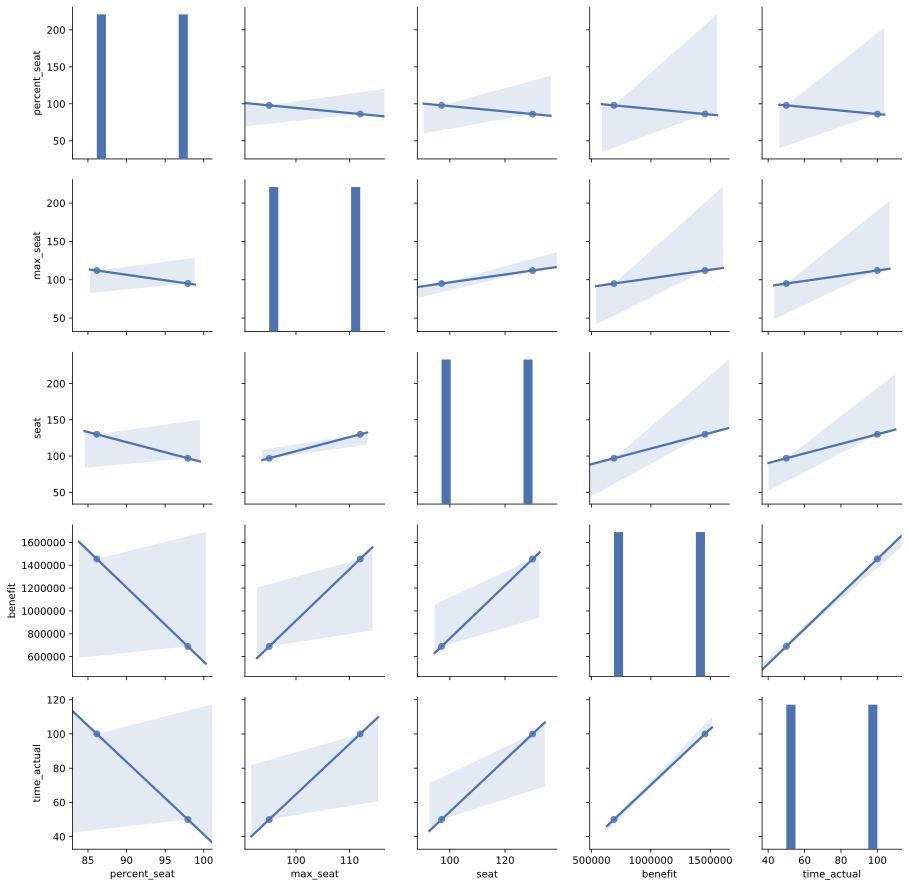

In [73]:
sns.pairplot(group_1, kind = 'reg')

In [74]:
benefit_mean = round(df_3.benefit.mean(),2)
benefit_median = df_3.benefit.median()
benefit_mode = df_3.benefit.mode()[0]

print('Среднее:',benefit_mean)
print('Медиана:',benefit_median)
print('Мода:',benefit_mode)

Среднее: 1060286.95
Медиана: 965903.975
Мода: 708000.99


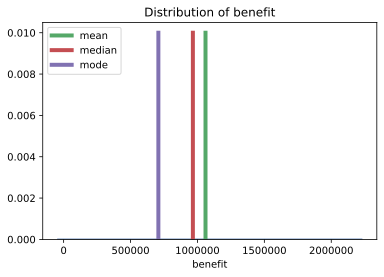

In [75]:
sns.distplot(df_3.benefit)

y = np.linspace(0, 0.01, 100)
plt.plot([benefit_mean]*100, y, label = 'mean', linestyle = '-', linewidth = 4)
plt.plot([benefit_median]*100, y, label = 'median', linestyle = '-', linewidth = 4)
plt.plot([benefit_mode]*100, y, label = 'mode', linestyle = '-', linewidth = 4)
plt.title('Distribution of benefit')
plt.legend(loc='upper left')
plt.show()

В данном датасете все рейсы Анапа-Новокузнецк оказались убыточными. Заполняемость этих рейсов менее 10%.

Если убыточные рейсы из Анапы совместить с рейсами из Краснодара (т.е повысить заполняемость рейсов из Краснодара в 2 раза) , то прибыльность рейсов в Новокузнецк повысится. Из Анапы в Краснодар можно добраться на "Ласточке", время в пути около 3 часов.

Стоит заметить, что для полноценного анализа лучше учесть еще ряд факторов, например, расходы на обслуживание, амортизацию, зарплату персонала.